In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import sys
import os

from pathlib import Path
p = Path(os.getcwd()).parents[1]
sys.path.append(p.__str__())

from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine
import json
import math

sns.set_style("whitegrid", {'axes.edgecolor' : '.1', 'axes.linewidth': 0.3, 'xtick.bottom': True,
    'ytick.left': True,
})

/Users/alvar/miniconda3/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BASE_DIR = "../../experiments/sou-sin10/"

# make plots dir
if not os.path.exists(BASE_DIR + "plots"):
    os.makedirs(BASE_DIR + "plots")

# make tables dir
if not os.path.exists(BASE_DIR + "tables"):
    os.makedirs(BASE_DIR + "tables")

In [4]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

#profiles= ["tensin-3x512-s003", "tensin-3x512-s03", "tensin-3x512-s3", "tensin-3x512-sl"] 
profiles= ["sin10-3x256-s003", "sin10-3x256-s03", "sin10-3x256-s3", "sin10-3x256-sl"]

names = [configs[p]["NAME"] for p in profiles]

prop_cycle = plt.rcParams['axes.prop_cycle']
plt_colors = prop_cycle.by_key()['color']

colors = [plt_colors[i] for i in range(len(profiles))]

reruns = 10

In [5]:
configs.keys()

KeysView(<configparser.ConfigParser object at 0x104086850>)

In [6]:


train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    train_stats[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/train_stats_{run}.json", "r") as f:
            train_stats[name].append(json.load(f))

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    results[name] = []
    for run in range(1, reruns+1):
        with open(f"{BASE_DIR}/results/{name}/results_{run}.json", "r") as f:
            results[name].append(json.load(f))

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    posterior_samples[name] = []
    # Load posterior samples
    for run in range(1, reruns+1):
        train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_{run}.npy")
        test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_{run}.npy")
        test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_{run}.npy")
        test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_{run}.npy")

        posterior_samples[name].append({
            "train": train,
            "test": test,
            "test_in_domain": test_in_domain,
            "test_out_domain": test_out_domain
        })

In [7]:
[results["sin10-3x256-s03"][i]["in_domain"]["error"]["rmse"] for i in range(reruns)]

[0.5711835026741028,
 0.5351855754852295,
 0.5445708632469177,
 0.5523589849472046,
 0.5941767692565918,
 0.5680861473083496,
 0.609194815158844,
 0.6344603896141052,
 0.5906391739845276,
 0.5865421295166016]

In [8]:
#Generate table for Train
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["train"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["train"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["train"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/train.csv")

print("TRAIN")
display(table)
print()

# Generate table for in_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["in_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["in_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["in_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/in_domain.csv")

print("IN DOMAIN")
display(table)
print()


# Generate table for out_domain
temp_t = pd.DataFrame(columns=["name", "lik-std-mean", "lik-std-std", "rmse-mean", "rmse-std", "mae-mean", "mae-std", "ll-mean", "ll-std"])

for p in profiles:
    name = configs[p]["NAME"]
    rmse_mean = np.mean([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    rmse_std = np.std([results[name][i]["out_domain"]["error"]["rmse"] for i in range(reruns)])
    mae_mean = np.mean([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    mae_std = np.std([results[name][i]["out_domain"]["error"]["mae"] for i in range(reruns)])
    ll_mean = np.mean([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    ll_std = np.std([results[name][i]["out_domain"]["error"]["loglikelihood"] for i in range(reruns)])
    lik_std_mean = [train_stats[name][i]["likelihood"]["mean"] for i in range(reruns)]
    lik_std_std = [train_stats[name][i]["likelihood"]["std"] for i in range(reruns)]
    temp_t = temp_t._append({
        "name": name,
        "lik-std-mean": np.mean(lik_std_mean),
        "lik-std-std": np.sqrt(np.var(lik_std_mean) + np.mean(lik_std_std)**2),
        "rmse-mean": rmse_mean,
        "rmse-std": rmse_std,
        "mae-mean": mae_mean,
        "mae-std": mae_std,
        "ll-mean": ll_mean,
        "ll-std": ll_std
    }, ignore_index=True)

table = pd.DataFrame(columns=["Name", "Likelihood_std", "RMSE", "MAE", "LL"])

round = 2
for p in profiles:
    name = configs[p]["NAME"]
    table["Name"] = temp_t["name"]
    table["Likelihood_std"] = temp_t["lik-std-mean"].round(round).astype(str).add('±').add(temp_t["lik-std-std"].multiply(2).round(round).astype(str))
    table["RMSE"] = temp_t["rmse-mean"].round(round).astype(str).add('±').add(temp_t["rmse-std"].multiply(2).round(round).astype(str))
    table["MAE"] = temp_t["mae-mean"].round(round).astype(str).add('±').add(temp_t["mae-std"].multiply(2).round(round).astype(str))
    table["LL"] = temp_t["ll-mean"].round(round).astype(str).add('±').add(temp_t["ll-std"].multiply(2).round(round).astype(str))

table = table.set_index("Name")
table.to_csv(f"{BASE_DIR}/tables/out_domain.csv")

print("OUT DOMAIN")
display(table)
print()


TRAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s003,0.03±0.0,0.06±0.02,0.05±0.02,0.95±0.07
sin10-3x256-s03,0.3±0.0,0.37±0.02,0.29±0.02,-0.5±0.04
sin10-3x256-s3,3.0±0.0,1.31±0.1,0.96±0.07,-2.23±0.02
sin10-3x256-sl,0.75±0.15,0.53±0.11,0.42±0.08,-0.98±0.19



IN DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s003,0.03±0.0,3.4±0.15,2.59±0.13,-242.22±26.3
sin10-3x256-s03,0.3±0.0,0.58±0.06,0.45±0.04,-0.88±0.11
sin10-3x256-s3,3.0±0.0,1.4±0.1,1.01±0.08,-2.24±0.02
sin10-3x256-sl,0.75±0.15,0.59±0.12,0.47±0.09,-1.02±0.2



OUT DOMAIN


,Likelihood_std,RMSE,MAE,LL
Name,,,,
sin10-3x256-s003,0.03±0.0,18.57±0.61,14.87±0.46,-811.15±148.61
sin10-3x256-s03,0.3±0.0,34.87±3.52,28.67±3.03,-28.1±4.95
sin10-3x256-s3,3.0±0.0,18.47±1.81,14.82±1.42,-4.71±0.19
sin10-3x256-sl,0.75±0.15,31.45±5.79,26.33±4.49,-6.63±1.64


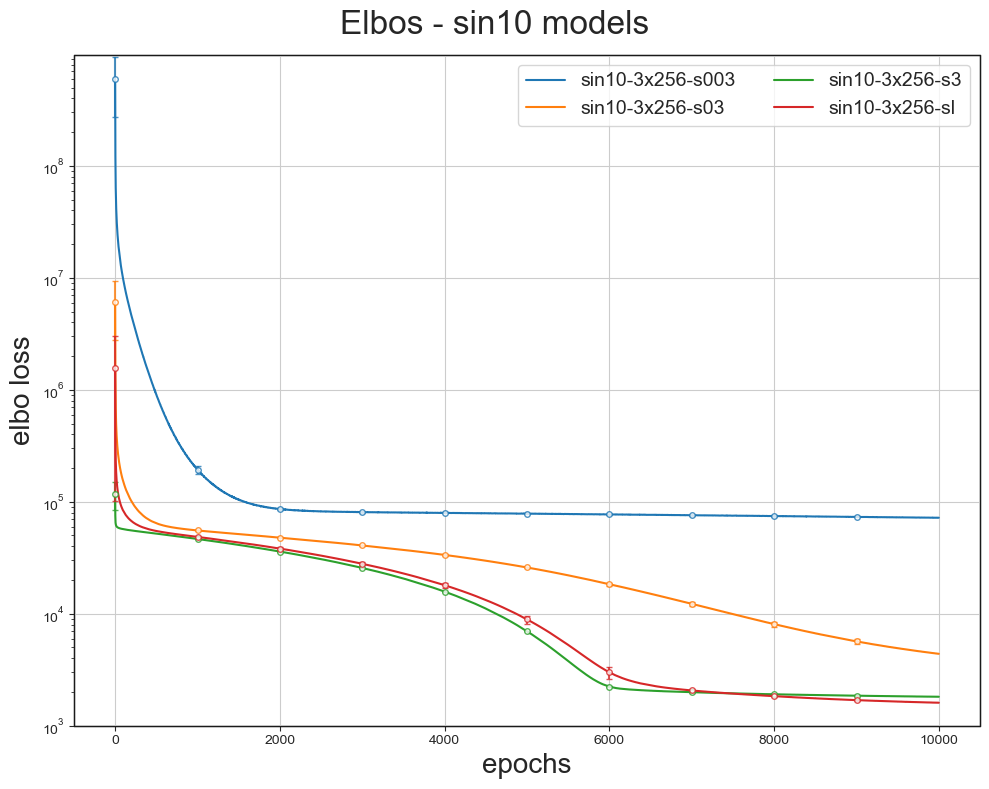

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Elbos - sin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    elbos = [train_stats[name][i]["elbos"] for i in range(reruns)]
    means = np.mean(elbos, axis=0)
    stds = np.std(elbos, axis=0)
    ax.plot(means, label=name, color=colors[i])

    err_range = list(range(0, len(means), 1000))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=4, mfc='white', alpha=0.8, fillstyle="full", capsize=2)

plt.ylim(bottom=1000)
ax.set_yscale("log", base=10)
ax.patch.set_linewidth(1) 
ax.patch.set_edgecolor('black')
ax.legend(fontsize=14, ncol=2)
ax.set_xlabel("epochs", fontsize=20)
ax.set_ylabel("elbo loss", fontsize=20)
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/elbos.svg", format="svg", dpi=300)
plt.show()

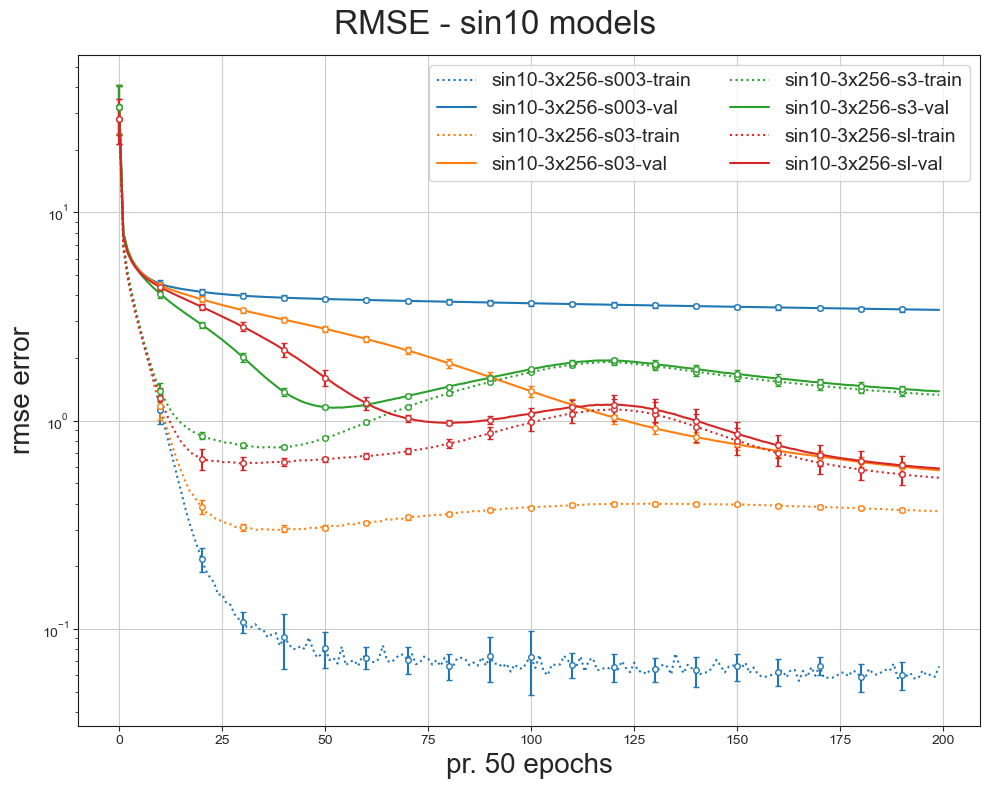

In [10]:
#plot rmse
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("RMSE - sin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_rmse"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.1, color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], fmt='o', color=colors[i], ms=4, mfc='white', alpha=1.0, fillstyle="full", capsize=2)

    ve = [train_stats[name][i]["val_rmse"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i], hatch='//')
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)
    ax.set_yscale('log')
ax.legend(fontsize=14, ncol=2)
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("rmse error", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/rmse.svg", format="svg", dpi=300)
plt.show()

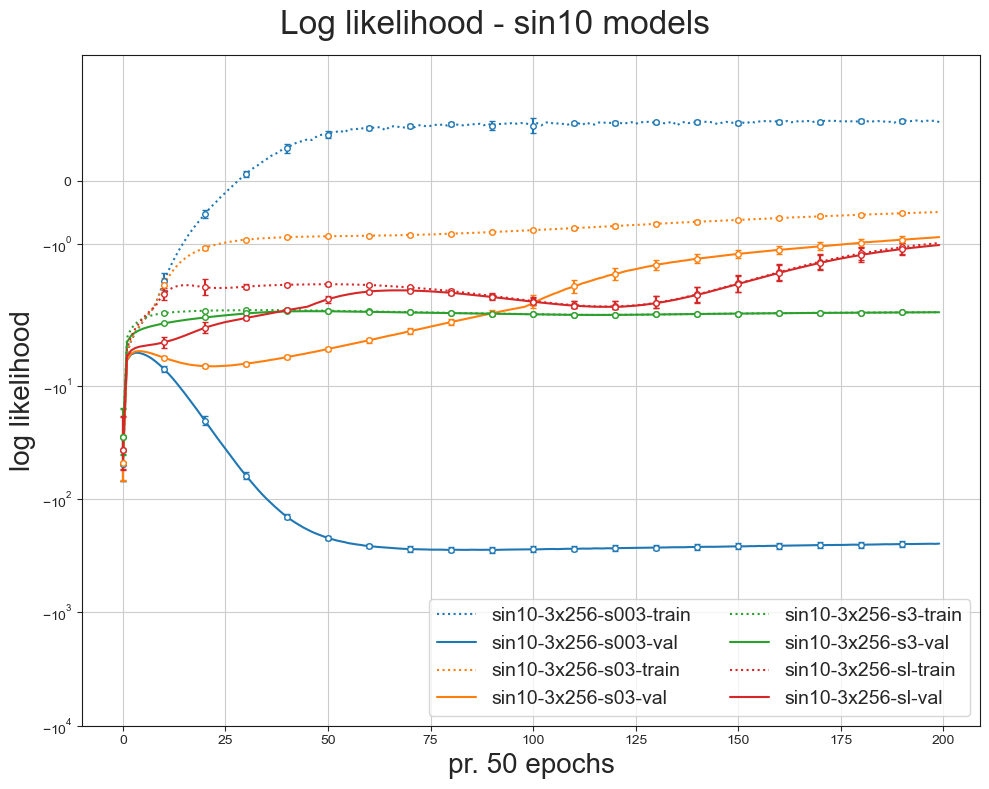

In [11]:
#plot log likelihood
fig, ax = plt.subplots(figsize=(10, 8))
fig.suptitle("Log likelihood - sin10 models", fontsize=24)
for i, p in enumerate(profiles):
    name = configs[p]["NAME"]
    te = [train_stats[name][i]["train_ll"] for i in range(reruns)]
    means = np.mean(te, axis=0)
    stds = np.std(te, axis=0)
    ax.plot(means, ':', label=f"{name}-train", color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)

    ve = [train_stats[name][i]["val_ll"] for i in range(reruns)]
    means = np.mean(ve, axis=0)
    stds = np.std(ve, axis=0)
    ax.plot(means, label=f"{name}-val", color=colors[i])
    err_range = list(range(0, len(means), 10))
    #ax.fill_between(range(len(means)), means-stds, means+(stds * 2), alpha=0.2, color=colors[i])
    plt.errorbar(err_range, means[err_range], yerr=stds[err_range], ms=4, fmt='o', color=colors[i], mfc='white', alpha=1.0, fillstyle="full", capsize=2)

plt.ylim(bottom=-10000, top=2)
ax.legend(fontsize=14, ncol=2, loc="lower right")
ax.set_yscale("symlog")
ax.set_xlabel("pr. 50 epochs", fontsize=20)
ax.set_ylabel("log likelihood", fontsize=20)
#tight layout
plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/ll.svg", format="svg", dpi=300)
plt.show()

In [12]:
results

{'sin10-3x256-s003': [{'train': {'error': {'rmse': 0.08648746460676193,
     'loglikelihood': 0.8598589301109314,
     'mae': 0.07218042016029358},
    'predictive_eval': {'kl_div_to_data': 0.9209087491035461,
     'mean_diff_to_data': 0.25364741683006287,
     'std_diff_to_data': 0.15694166719913483}},
   'test': {'error': {'rmse': 13.002691268920898,
     'loglikelihood': -497.1761169433594,
     'mae': 8.594435691833496},
    'predictive_eval': {'kl_div_to_data': 1044.10009765625,
     'mean_diff_to_data': 9.071805953979492,
     'std_diff_to_data': 0.1869625598192215}},
   'in_domain': {'error': {'rmse': 3.4550774097442627,
     'loglikelihood': -255.2025604248047,
     'mae': 2.6277472972869873},
    'predictive_eval': {'kl_div_to_data': 74.42587280273438,
     'mean_diff_to_data': 2.812844753265381,
     'std_diff_to_data': 0.15048737823963165}},
   'out_domain': {'error': {'rmse': 18.061403274536133,
     'loglikelihood': -738.1116333007812,
     'mae': 14.570764541625977},
    

In [13]:
run = 1

name1 = configs[profiles[1]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}


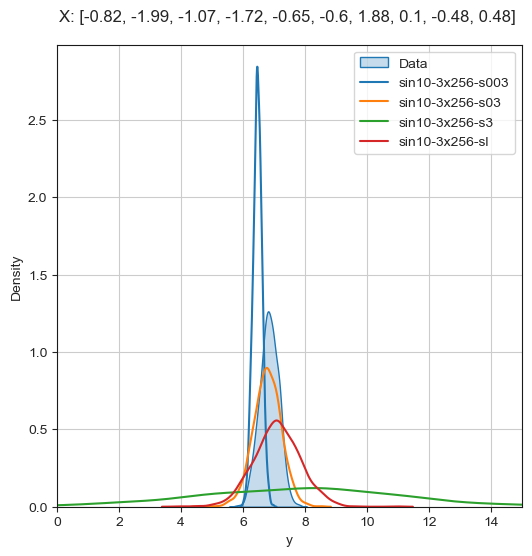

In [14]:
# Plot posterior samples
labels = [configs[p]["NAME"] for p in profiles]
x_samp = data_samples["train_x"][1]
train_samp = np.array(data_samples["train_dist_samples"][:, 1])
pred_train_samples = [np.array(posterior_samples[p][run-1]["train"][:, 1]) for p in profiles]
plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, figsize=(6,6), x_sample=x_samp, title="Posterior samples - Train", save_path=f"{BASE_DIR}/results/posterior_comparison.png", xlim=(0, 15))

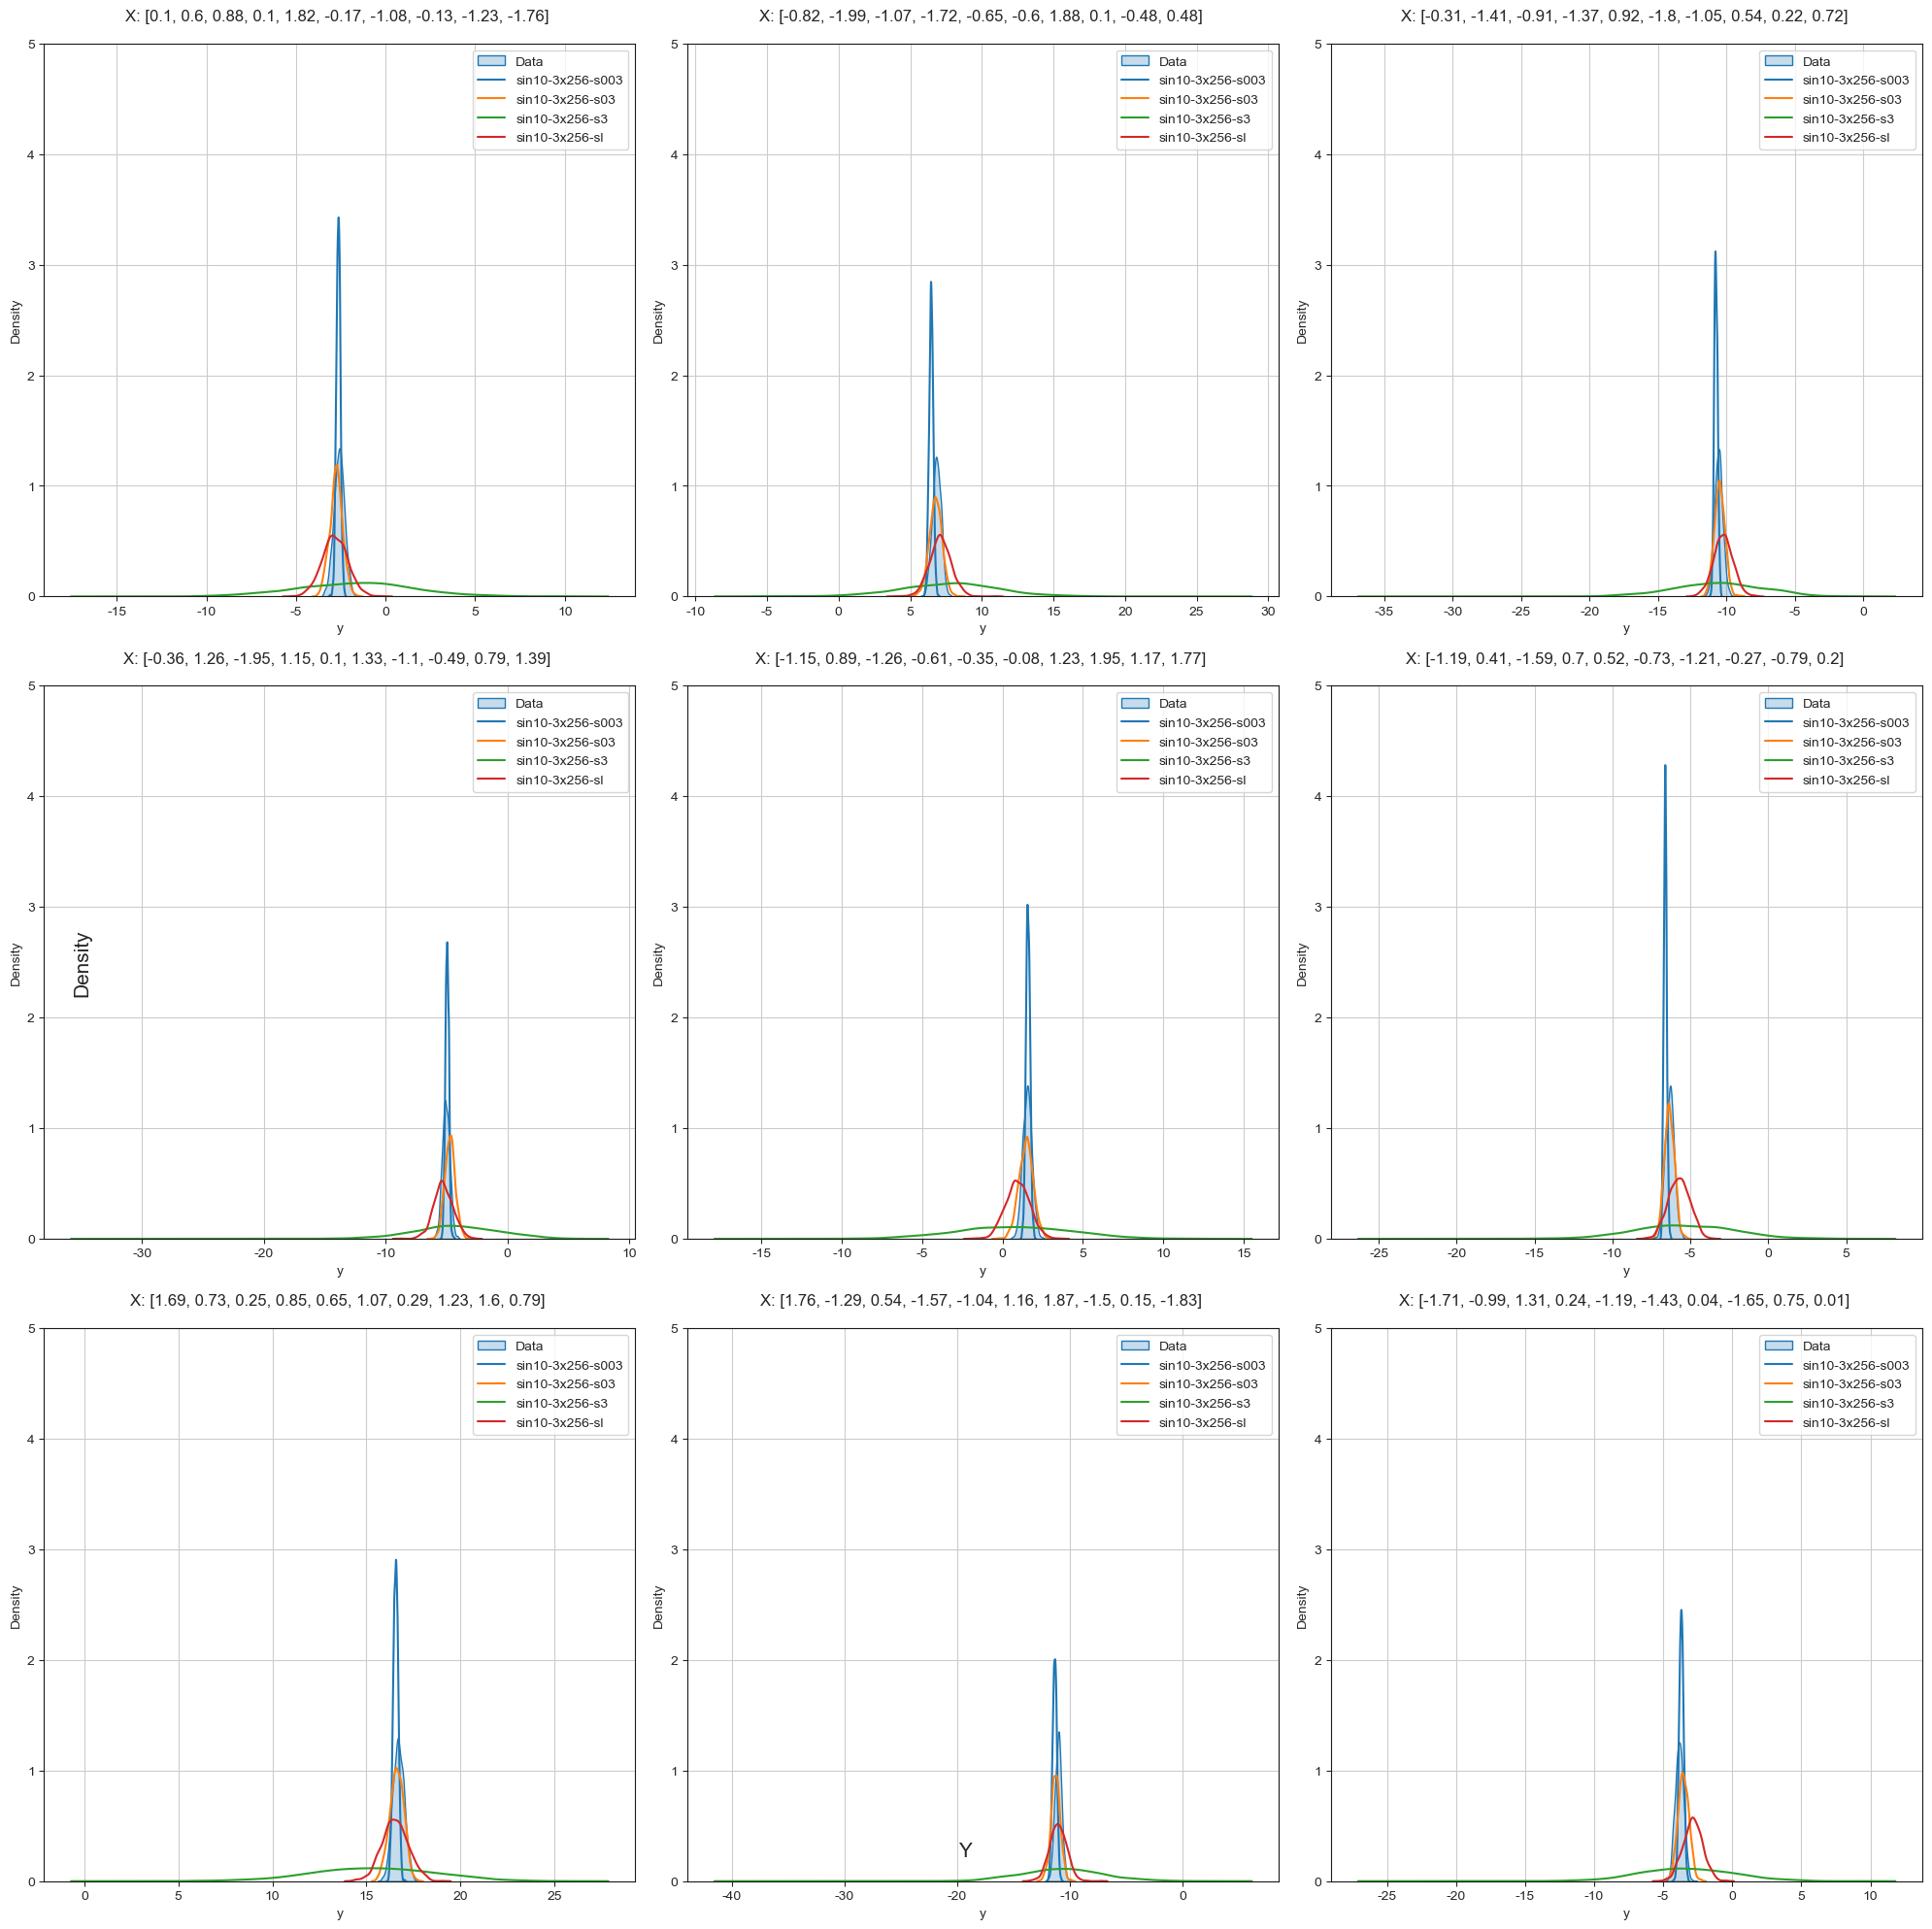

In [15]:

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.tight_layout()

plt.show()

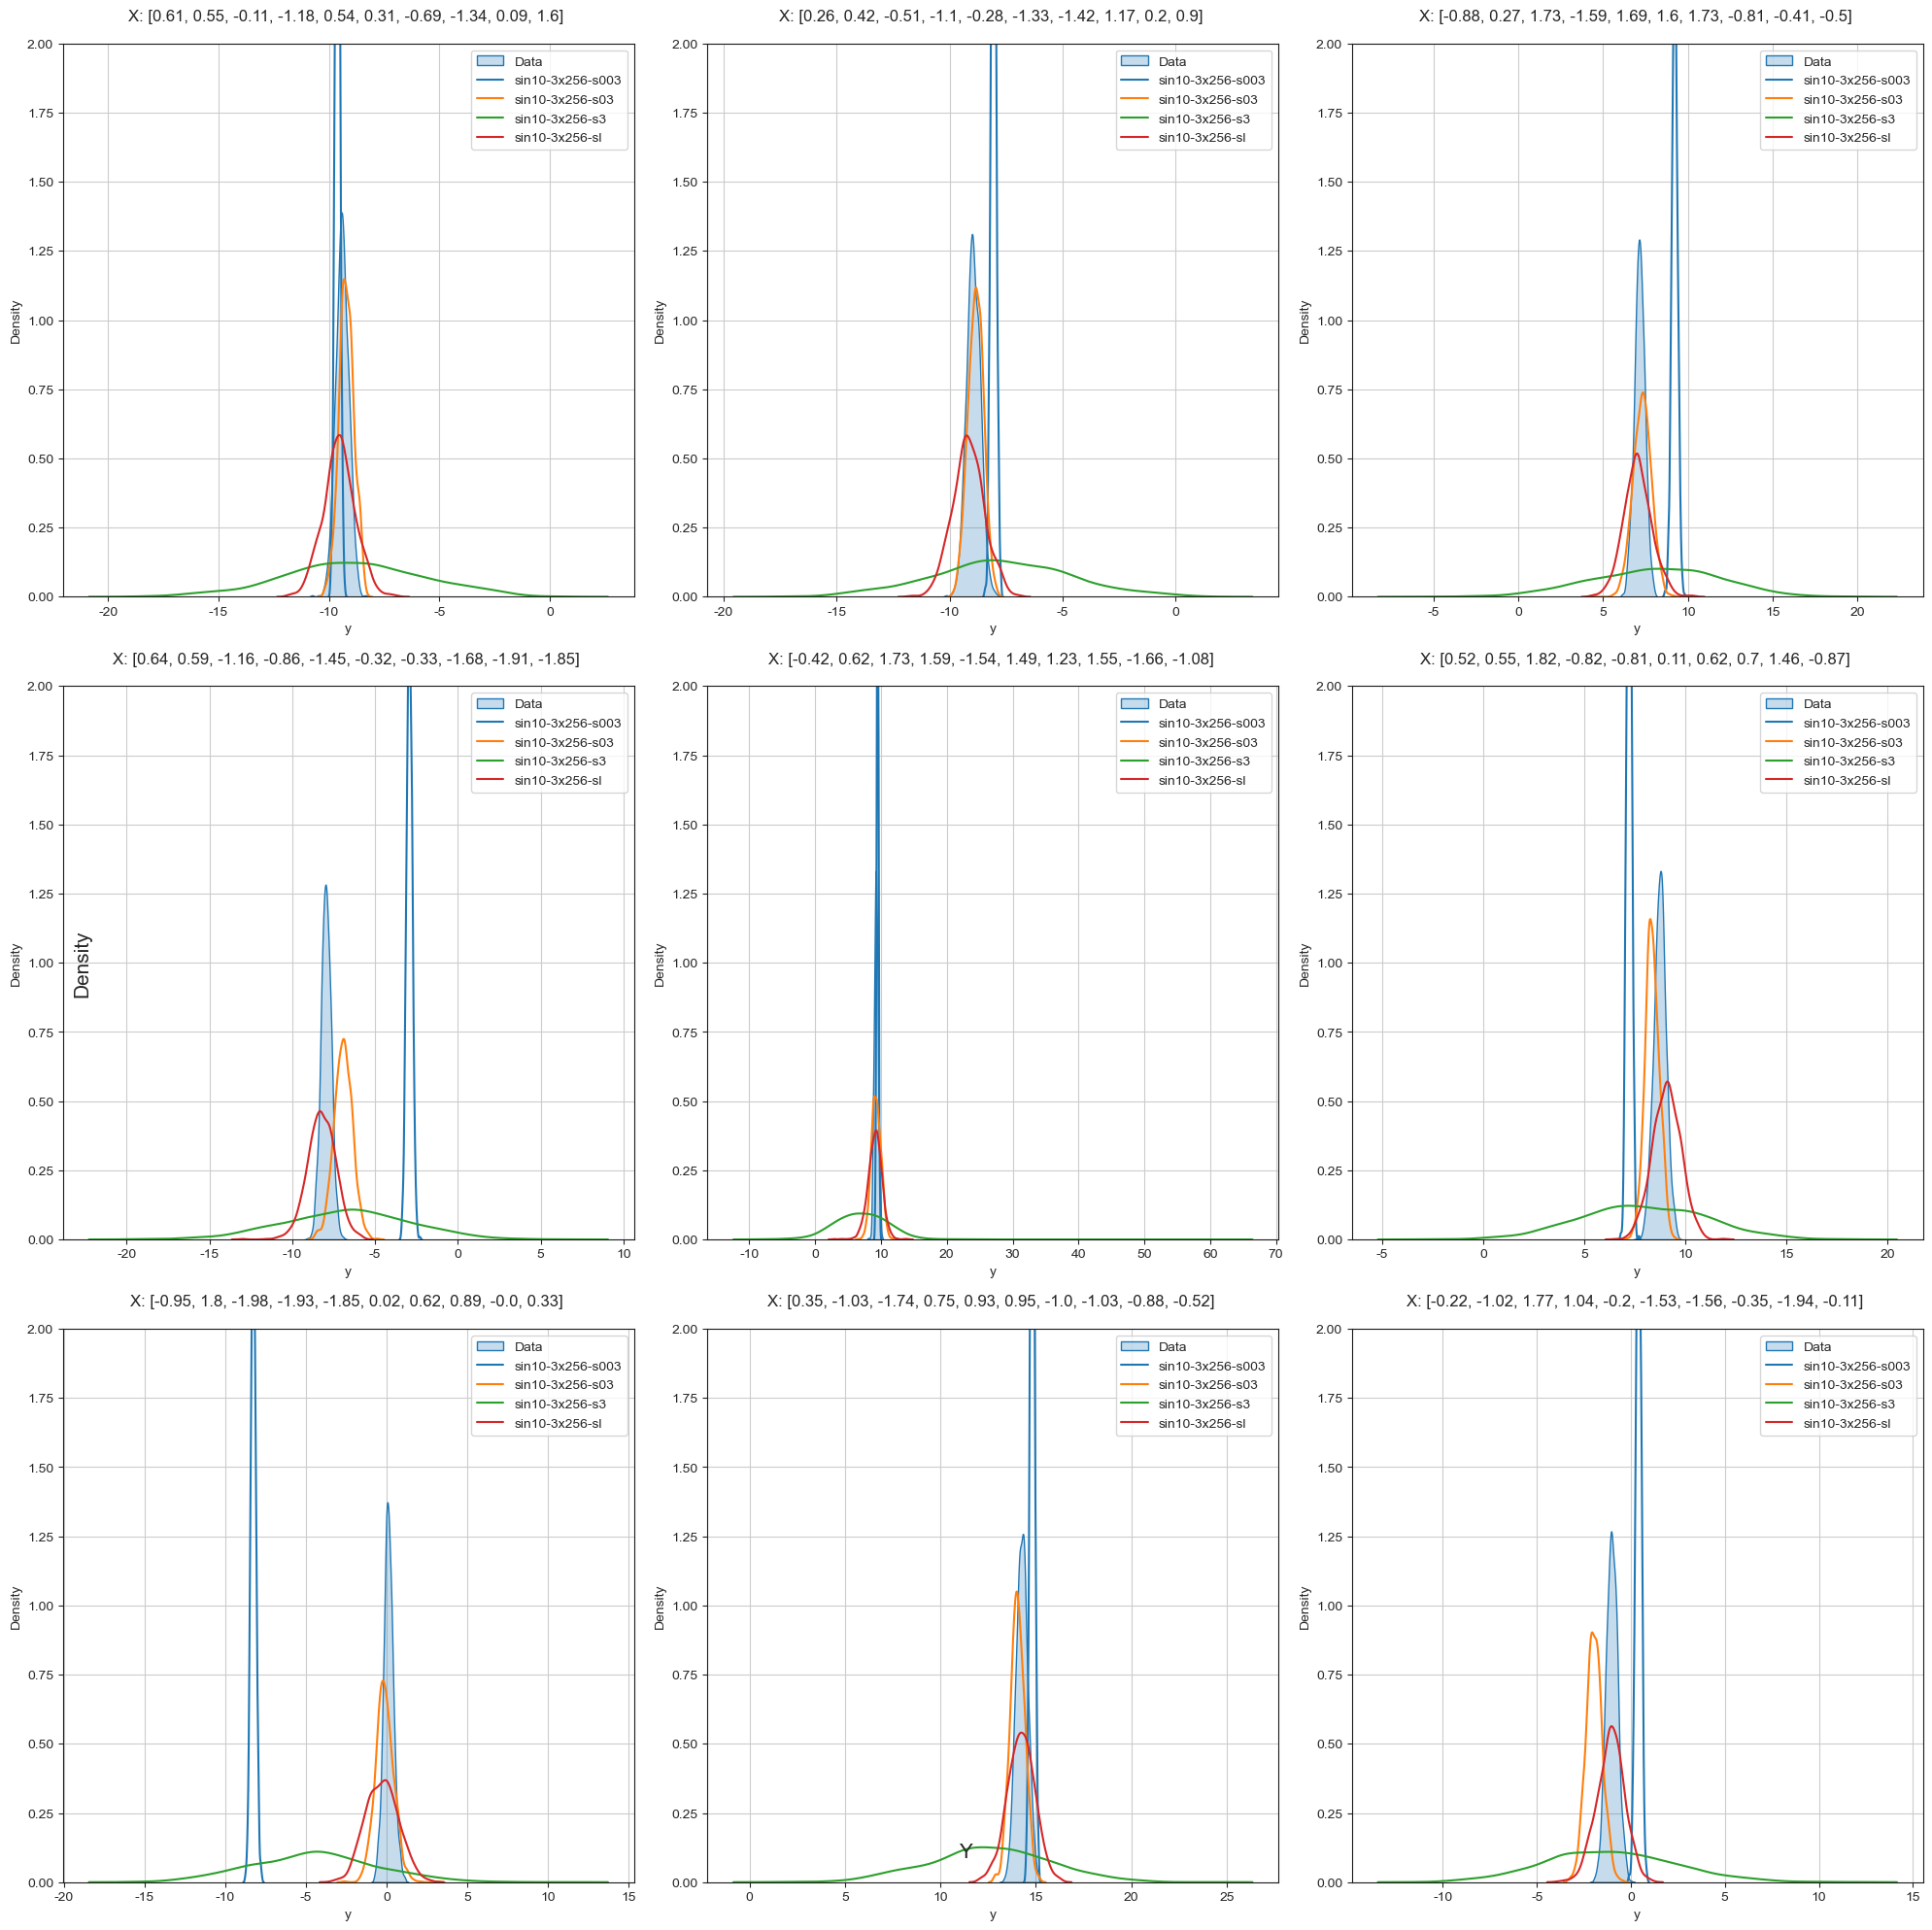

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["test_in_domain_x"][i]
    train_samp = data_samples["test_in_domain_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["test_in_domain"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 2])

plt.tight_layout()

plt.show()

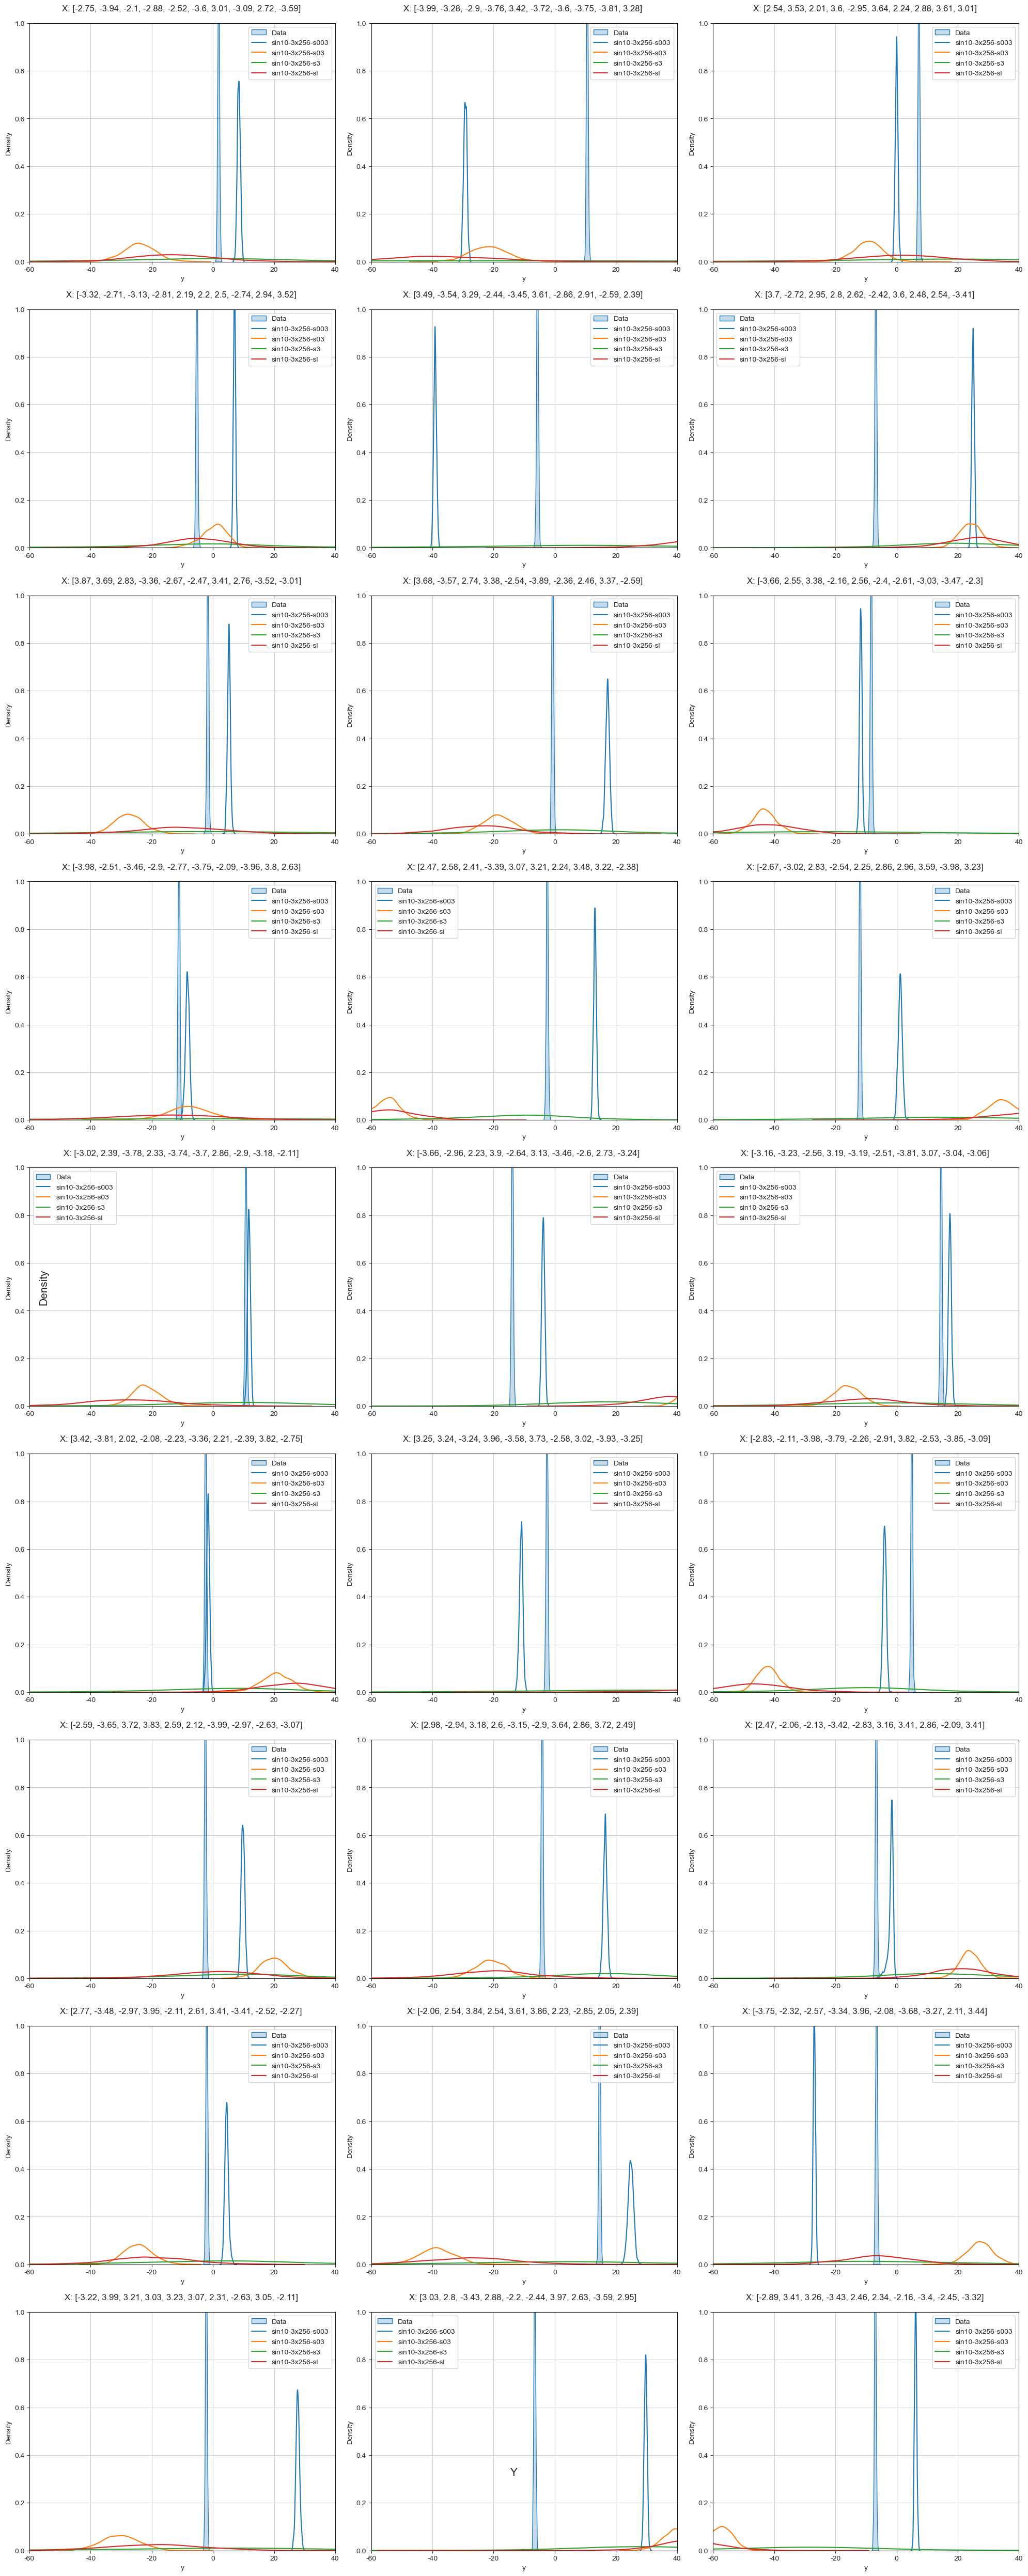

In [31]:

fig, axs = plt.subplots(9, 3, figsize=(20, 50))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["test_out_domain_x"][i]
    train_samp = data_samples["test_out_domain_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p][run-1]["test_out_domain"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)
    ax.set_ylim([0, 1])
    ax.set_xlim([-60, 40])

plt.tight_layout()

plt.show()